In [1]:
datasetName = 'brain_VisualCortexFrontalCortexCerebellum_Lake2017'
#datasetName value: organ_tissue_authorYear without space
dataFormat = 'tsv'
#dataFormat value: tsv (tab separated), 10X (sparse)
setwd("/stor/public/hcad/brain_VisualCortexFrontalCortexCerebellum_Lake2017")

In [2]:
library(Seurat)
library(data.table)
library(ggplot2)
# Load the organized dataset
if(dataFormat == 'tsv'){
    data.matrix <- data.table::fread(paste0(datasetName,"_expression.tsv.gz"), h = T, data.table = F)
} else{
   system(paste0("tar -zxvf ", datasetName, "_expression.tar.gz")) #Invoke the unix command
   data.matrix <- Read10X(data.dir = paste0(datasetName,"_expression"))
   # data.dir: Directory containing the matrix.mtx, genes.tsv (or features.tsv), and barcodes.tsv files provided by 10X.
}
# Load the metadata and annotation
data.metadata <- read.table(file = paste0(datasetName,"_metadata.tsv"), h = T, sep = "\t", row.names = 5)
data.annotation <- read.table(file = paste0(datasetName,"_annotation.tsv"), h = T, sep = "\t", row.names = 1)
if (file.exists(paste0(datasetName,"_annotation.v2.tsv"))) {
    data.annotation2 <- read.table(file = paste0(datasetName,"_annotation.v2.tsv"), h = T, sep = "\t", row.names = 1)
}


In [3]:
data.matrix[1:5, 1:5]
data.metadata[1:5, ]
data.annotation[1:5,]

,cell_ID,Ex1_occ17_AAGTGAGTGACC,Ex1_occ23_CCAGTACGCATC,Ex1_occ24_CCAGGCCTTTCG,Ex1_occ24_CGTTACTGAGAG
,<chr>,<int>,<int>,<int>,<int>
1,A1BG,0,0,0,0
2,A1BG-AS1,0,0,0,0
3,A1CF,0,0,0,0
4,A2M,0,0,0,0
5,A2M-AS1,0,0,0,0


,organ,region,subregion,sample_status,donor_ID,donor_gender,donor_age
,<fct>,<fct>,<lgl>,<fct>,<int>,<lgl>,<lgl>
Gran_cbm1_TTAATCAGTCGC,Brain,cbm,NA,normal,1,NA,NA
Gran_cbm1_ACAACGACATCC,Brain,cbm,NA,normal,1,NA,NA
Gran_cbm1_TATGTCTATATG,Brain,cbm,NA,normal,1,NA,NA
Gran_cbm1_TAATGGAAAATA,Brain,cbm,NA,normal,1,NA,NA
Gran_cbm1_CTGGACTACAGC,Brain,cbm,NA,normal,1,NA,NA


[1] Gran Gran Gran Gran Gran
33 Levels: Ast End Ex1 Ex2 Ex3a Ex3b Ex3c Ex3d Ex3e Ex4 Ex5a Ex5b Ex6a ... Purk2

In [4]:
row.names(data.matrix) = data.matrix[, 1]
data.matrix <- data.matrix[, -1]
data.matrix[1:5, 1:5]

,Ex1_occ17_AAGTGAGTGACC,Ex1_occ23_CCAGTACGCATC,Ex1_occ24_CCAGGCCTTTCG,Ex1_occ24_CGTTACTGAGAG,Ex1_occ12_GCCACACGGGGA
,<int>,<int>,<int>,<int>,<int>
A1BG,0,0,0,0,0
A1BG-AS1,0,0,0,0,0
A1CF,0,0,0,0,0
A2M,0,0,0,0,0
A2M-AS1,0,0,0,0,0


In [5]:
dim(data.matrix)

[1] 43327 35289

In [6]:
data.matrix <- na.omit(data.matrix)

In [7]:
# Pre-processing
min.cells = 3
min.features = 300
nFeature_RNA_range = c(300, 5000)
percent.mt.thre = 10
# Modify the default value of these parameters according to original paper
dataobj <- CreateSeuratObject(counts = data.matrix, project = datasetName, min.cells = min.cells, min.features = min.features, meta.data = data.metadata)
dataobj <- AddMetaData(dataobj, metadata = data.annotation)
if (file.exists(paste0(datasetName,"_annotation.v2.tsv"))) {
    dataobj <- AddMetaData(dataobj, metadata = data.annotation2)
}

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


In [8]:
dataobj@assays

$RNA
Assay data with 26474 features for 31240 cells
First 10 features:
 A1BG-AS1, A1CF, A2M, A2M-AS1, A2ML1, A2ML1-AS1, A2MP1, A3GALT2, A4GALT,
AAAS 


In [9]:
# QC
dataobj[["percent.mt"]] <- PercentageFeatureSet(dataobj, pattern = "^[Mm][Tt]")
dataobj <- subset(dataobj, subset = nFeature_RNA > nFeature_RNA_range[1] & nFeature_RNA < nFeature_RNA_range[2] & percent.mt < percent.mt.thre)
dataobj@assays

$RNA
Assay data with 26474 features for 31165 cells
First 10 features:
 A1BG-AS1, A1CF, A2M, A2M-AS1, A2ML1, A2ML1-AS1, A2MP1, A3GALT2, A4GALT,
AAAS 


In [10]:
# Normalization
# Two approaches
# 1. run standard log normalization 
dataobj <- NormalizeData(dataobj, normalization.method = "LogNormalize", scale.factor = 10000)
dataobj <- FindVariableFeatures(dataobj, selection.method = 'vst', nfeatures = 2000) # default feature number, nfeatures = 2000
dataobj <- ScaleData(dataobj, features = VariableFeatures(dataobj))
# 2. run sctransform 
# dataobj <- SCTransform(dataobj, vars.to.regress = "percent.mt", do.correct.umi = TRUE, do.scale = TRUE, do.center = TRUE)

Centering and scaling data matrix



In [11]:
# Dimensional Reduction
dataobj <- RunPCA(dataobj, features = VariableFeatures(object = dataobj))
# Determine the ‘dimensionality’ of the dataset according to elbow plot
pdf(paste0(datasetName,"seurat.elbowplot.pdf"))
ElbowPlot(dataobj) 

PC_ 1 
Positive:  CHN1, LDB2, NRGN, PHACTR1, ATRNL1, KCNQ5, KHDRBS2, OLFM1, ENC1, R3HDM1 
	   ASIC2, CHRM3, KCNIP4, IQCJ-SCHIP1, LRRTM4, LINGO2, RP11-191L9.4, CAMK2A, CDH12, ADGRL2 
	   KCTD16, PCDH7, ERICH1-AS1, HS6ST3, CABP1, FAM19A1, LMO4, GRM7, NELL1, AC011288.2 
Negative:  QKI, PLP1, CTNNA3, NCKAP5, MOBP, RNF220, PTGDS, NEAT1, SLC1A3, DOCK5 
	   DOCK10, CLDN11, FRMD4B, ERBB4, MAML2, NFIA, MBP, FBXL7, CERCAM, LINC00609 
	   AC012593.1, CHD7, SCD, ENPP2, RFTN2, LINC01608, CNDP1, BCAS1, C10orf90, PREX2 
PC_ 2 
Positive:  GAD1, FSTL5, GRIK2, GAD2, GRID2, NXPH1, SLC24A3, RELN, RORA, RP11-123O10.4 
	   BTBD11, KAZN, DLX6-AS1, PTPRM, GRIK1, DNER, MYO16, KIT, ANK1, RAB3C 
	   ADARB2, SGCZ, SLC35F4, KCND2, GRIP1, C8orf34, CXCL14, KIAA1211, ERBB4, RBMS3 
Negative:  PLP1, MOBP, MBP, RNF220, CTNNA3, SLC44A1, DPYD, CLDN11, CERCAM, ENPP2 
	   LINC00609, KCNH8, DOCK5, CNDP1, CARNS1, LINC01608, PTPRD, PIP4K2A, MOG, CNP 
	   SCD, C10orf90, FRMD4B, MAL, SHROOM4, COL4A5, MYRF, ASPA, FA2H, ABCA8 
PC_

In [22]:
dev.off()
pcDim = 50 # set as 75 in this case 
dataobj <- RunUMAP(dataobj, dims = 1:pcDim)
DimPlot(dataobj, reduction = "umap", label = TRUE)
# ggsave(paste0(datasetName,".seurat.umap.tiff", plot = p_umap, width = 8, height = 5)

pdf 
  3

23:04:37 UMAP embedding parameters a = 0.9922 b = 1.112

23:04:37 Read 31165 rows and found 50 numeric columns

23:04:37 Using Annoy for neighbor search, n_neighbors = 30

23:04:37 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*

|

23:04:42 Writing NN index file to temp file /tmp/Rtmp9RqT8N/file3e5839f9e190

23:04:42 Searching Annoy index using 1 thread, search_k = 3000

23:04:52 Annoy recall = 100%

23:04:53 Commencing smooth kNN distance calibration using 1 thread

23:04:54 Initializing from normalized Laplacian + noise

23:04:55 Commencing optimization for 200 epochs, with 1507402 positive edges

23:05:30 Optimization finished



Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 31165
Number of edges: 1512148

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8611
Number of communities: 34
Elapsed time: 6 seconds


08:35:52 UMAP embedding parameters a = 0.9922 b = 1.112

08:35:52 Read 31165 rows and found 50 numeric columns

08:35:52 Using Annoy for neighbor search, n_neighbors = 30

08:35:52 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*

|

08:35:58 Writing NN index file to temp file /tmp/Rtmp9RqT8N/file3e586663478e

08:35:58 Searching Annoy index using 1 thread, search_k = 3000

08:36:08 Annoy recall = 100%

08:36:09 Commencing smooth kNN distance calibration using 1 thread

08:36:11 Initializing from normalized Laplacian + noise

08:36:12 Commencing optimization for 200 epochs, with 1507402 positive edges

08:36:47 Optimization finished



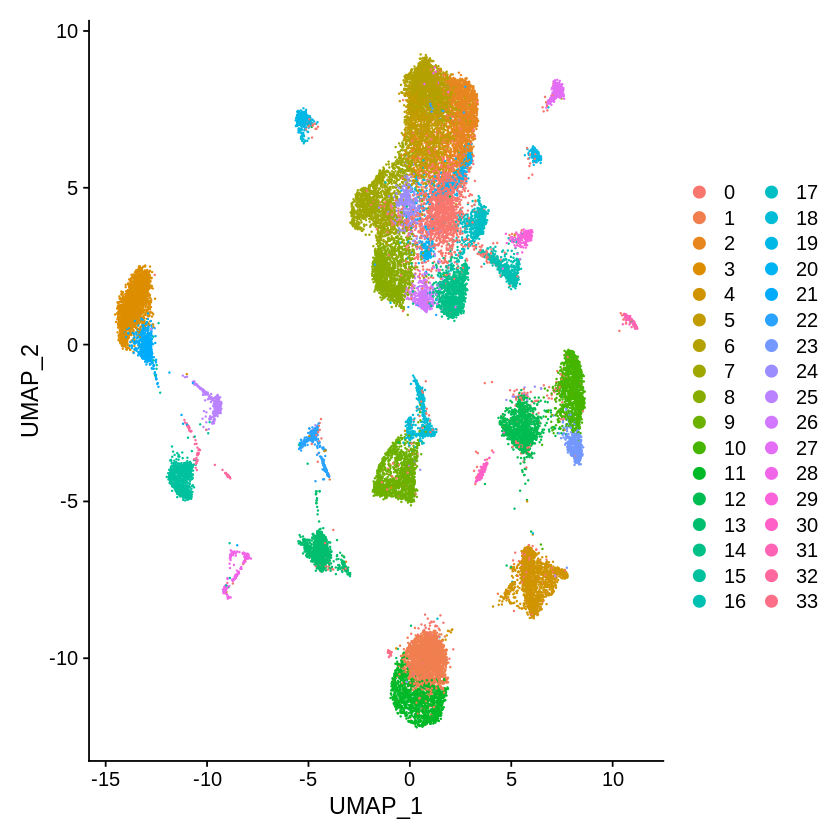

In [32]:
# Cluster the cells
dataobj <- FindNeighbors(dataobj, reduction = "pca", dims = 1:pcDim, nn.eps = 0.5)
dataobj <- FindClusters(dataobj, resolution = 1.8, n.start = 10)
# umap
dataobj <- RunUMAP(dataobj, dims = 1:pcDim)
DimPlot(dataobj, reduction = "umap")

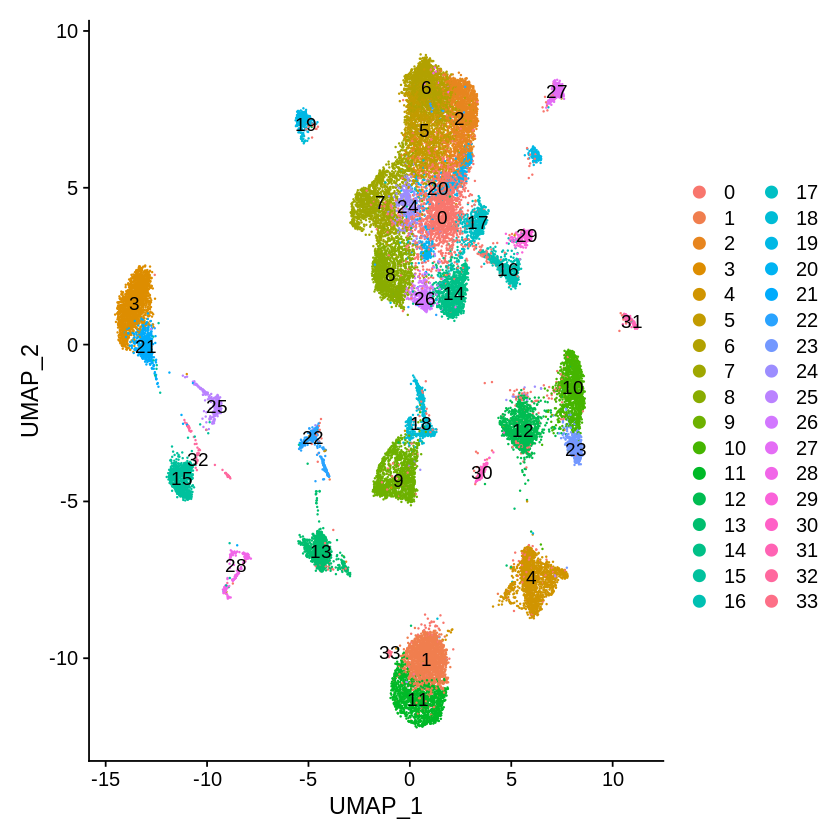

In [33]:
p_umap <- DimPlot(dataobj, reduction = "umap", label = TRUE)
p_umap
orig.ident <- as.character(as.data.frame(dataobj@active.ident)[, 1])

In [34]:
ggsave(paste0(datasetName,".seurat.umap.tiff"), plot = p_umap, width = 8, height = 5)

In [28]:
annotation <- as.data.frame(cbind(colnames(data.matrix)[colnames(data.matrix) %in% labels(Idents(dataobj))], as.character(data.annotation[colnames(data.matrix) %in% labels(Idents(dataobj)), ]), seurat_cluster = as.character(Idents(dataobj))))
annotation <- annotation[, -1]
annotation <- annotation[order(annotation$seurat_cluster), ]
print(annotation)

         V2 seurat_cluster
2      Gran              0
4      Gran              0
146    Gran              0
582    Gran              0
667    Gran              0
678    Gran              0
729    Gran              0
854    Gran              0
980    Gran              0
986    Gran              0
1091   Gran              0
1093   Gran              0
1099   Gran              0
1216   Gran              0
1221   Gran              0
1224   Gran              0
1232   Gran              0
1373   Gran              0
1412   Gran              0
1417   Gran              0
1430   Gran              0
1435   Gran              0
1585   Gran              0
1586   Gran              0
1590   Gran              0
1592   Gran              0
1595   Gran              0
1601   Gran              0
1605   Gran              0
1610   Gran              0
1613   Gran              0
1757   Gran              0
1761   Gran              0
1803   Gran              0
1869   Gran              0
1890   Gran              0
1

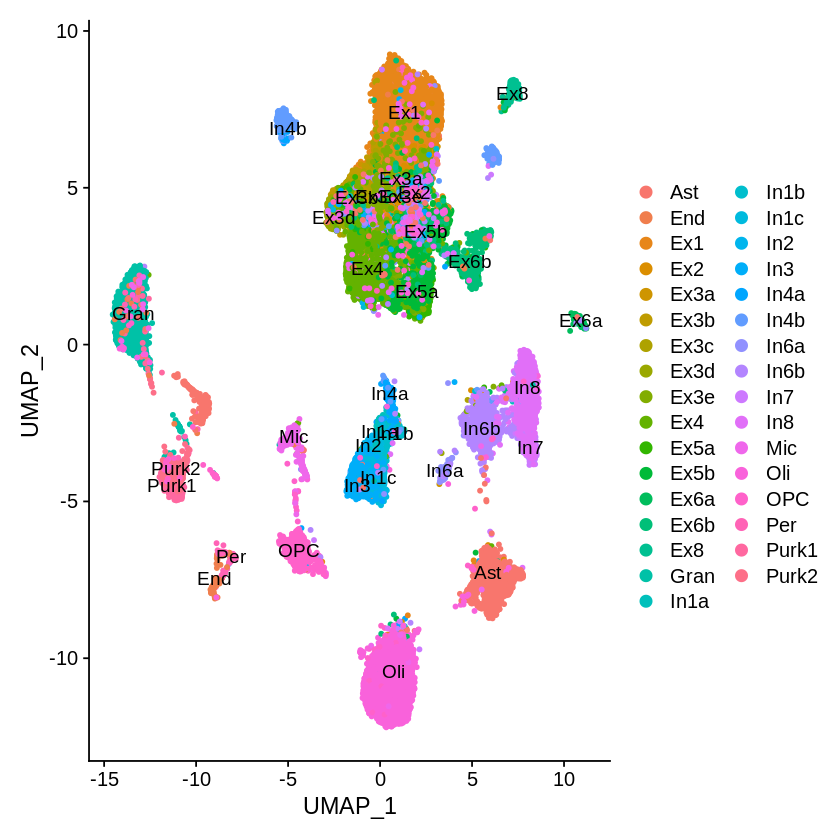

In [35]:
p_umap2 <- DimPlot(dataobj, reduction = "umap", label = TRUE, group.by = "cell_cluster", pt.size=1)
p_umap2

In [36]:
ggsave(paste0(datasetName,".seurat.umap_orig.tiff"), plot = p_umap2, width = 8, height = 5)

In [39]:
new.cluster.ids <- c( 'Brain-Nerve tissue-Excitatory neuron-GRM5', 'Brain-Nerve tissue-Oligodendrocyte-MOBP', 'Brain-Nerve tissue-Excitatory neuron-SLC17A7',
                    'Brain-Nerve tissue-Granule cell-GRM4', 'Brain-Nerve tissue-Astrocyte-SLC1A2', 'Brain-Nerve tissue-Excitatory neuron-SLC17A7',
                    'Brain-Nerve tissue-Excitatory neuron-SLC17A7', 'Brain-Nerve tissue-Excitatory neuron-SLC17A7', 'Brain-Nerve tissue-Excitatory neuron-SLC17A7',
                    'Brain-Nerve tissue-Inhibitory neuron-GAD1', 'Brain-Nerve tissue-Inhibitory neuron-GAD1', 'Brain-Nerve tissue-Oligodendrocyte-MOBP',
                    'Brain-Nerve tissue-PV Inhibitory neuron-PVALB', 'Brain-Nerve tissue-Oligodendrocyte precursor cell-OLIG1', 'Brain-Nerve tissue-Excitatory neuron-SLC17A7',
                    'Brain-Nerve tissue-Purkinje cell-RYR1 and GLCE', 'Brain-Nerve tissue-Excitatory neuron-SLC17A7', 'Brain-Nerve tissue-Excitatory neuron-SLC17A7',
                    'Brain-Nerve tissue-Inhibitory neuron-GAD1', 'Brain-Nerve tissue-Inhibitory neuron-GAD1', 'Brain-Nerve tissue-Excitatory neuron-SLC17A7',
                    'Brain-Nerve tissue-Granule cell-GRM4', 'Brain-Nerve tissue-Microglia-APBB1IP', 'Brain-Nerve tissue-Inhibitory neuron-GAD1',
                    'Brain-Nerve tissue-Excitatory neuron-SLC17A7', 'Brain-Nerve tissue-Astrocyte-SLC4A4', 'Brain-Nerve tissue-Excitatory neuron-SLC17A7',
                    'Brain-Nerve tissue-Excitatory neuron-SLC17A7', 'Brain-Epithelial tissue-Endothelial cell-FLT1/Brain-Connective tissue-Pericyte-COBLL1', 'Brain-Nerve tissue-Excitatory neuron-SLC17A7', 
                    'Brain-Nerve tissue-PV inhibitory neuron-PVALB', 'Brain-Nerve tissue-Excitatory neuron-HTR2C', 'Brain-Nerve tissue-Purkinje cell-RYR1 and GLCE',
                    'Brain-Nerve tissue-Oligodendrocyte-MOBP')
names(new.cluster.ids) <- levels(dataobj)
dataobj <- RenameIdents(dataobj, new.cluster.ids)

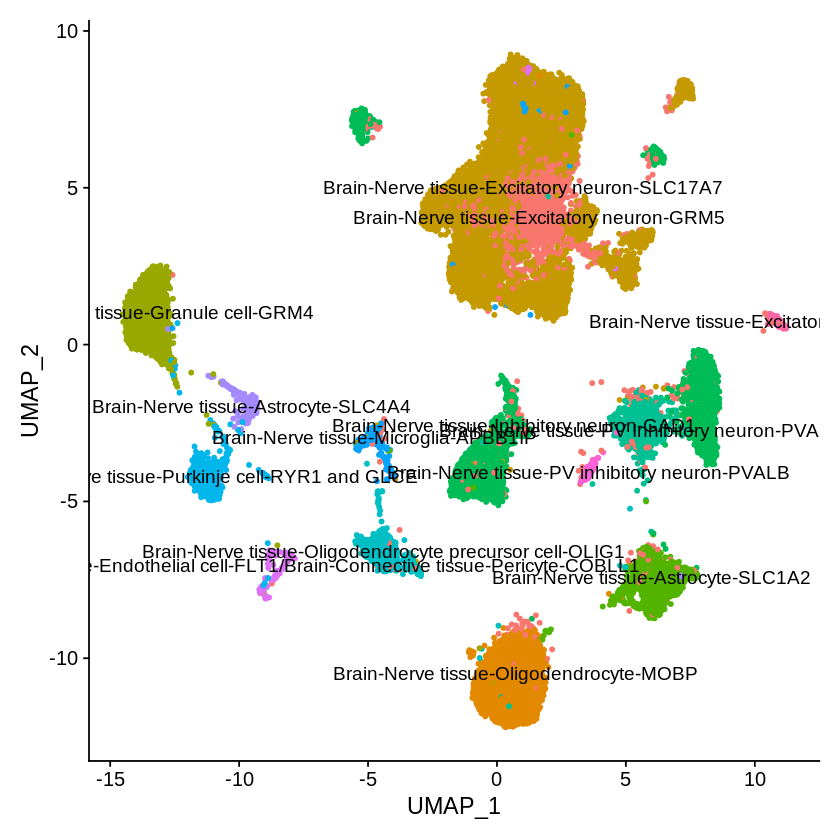

In [30]:
p_umap2 <- DimPlot(dataobj, reduction = "umap", label = TRUE, pt.size=1) + NoLegend()
p_umap2

In [31]:
ggsave(paste0(datasetName,".seurat.umap_hcad.tiff"), plot = p_umap2, width = 8, height = 5)

In [27]:
# Finding cluster markers 
dataobj.markers <- FindAllMarkers(dataobj, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
write.table(dataobj.markers, file = paste0(datasetName,".seurat.markers.txt"), sep = "\t", quote = F, row.names = F, col.names = T)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11

Calculating cluster 12

Calculating cluster 13

Calculating cluster 14

Calculating cluster 15

Calculating cluster 16

Calculating cluster 17

Calculating cluster 18

Calculating cluster 19

Calculating cluster 20

Calculating cluster 21

Calculating cluster 22

Calculating cluster 23

Calculating cluster 24

Calculating cluster 25

Calculating cluster 26

Calculating cluster 27

Calculating cluster 28

Calculating cluster 29

Calculating cluster 30

Calculating cluster 31

Calculating cluster 32

Calculating cluster 33



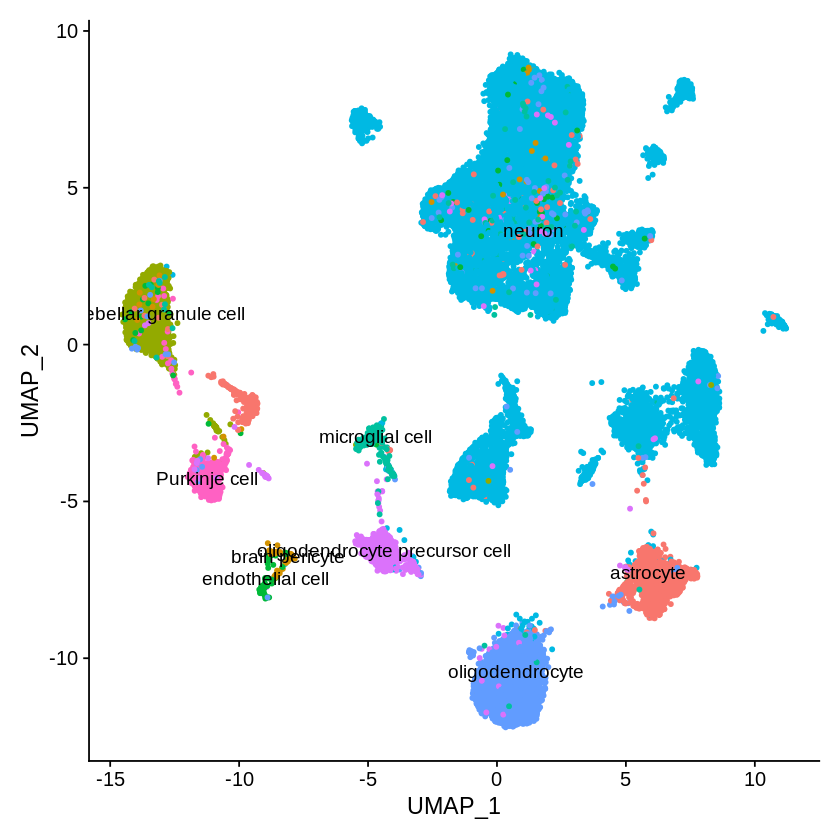

In [37]:
p_umap3 <- DimPlot(dataobj, reduction = "umap", label = TRUE, group.by = "cell_ontology_class", pt.size=1) + NoLegend()
p_umap3

In [38]:
ggsave(paste0(datasetName,".seurat.umap_cb.tiff"), plot = p_umap3, width = 8, height = 5)

In [ ]:
saveRDS(dataobj, file = paste0(datasetName,".seuratobj.rds"))